In [1]:
import torch
#torch.set_default_dtype(torch.float64)
import numpy as np
import ase.io

from pytorch_prototype.code_pytorch import *
from pytorch_prototype.utilities import *
from pytorch_prototype.clebsch_gordan import ClebschGordan

from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species

from matplotlib import pyplot as plt
import tqdm
import time

from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )

In [2]:
METHANE_PATH = 'methane.extxyz'
HARTREE_TO_EV = 27.211386245988

train_slice = '0:900'
test_slice = '900:1000'

L_MAX = 6
clebsch = ClebschGordan(L_MAX)

HYPERS_INITIAL = {
    'interaction_cutoff': 6.3,
    'max_radial': 20,
    'max_angular': L_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR'
}

BATCH_SIZE = 2000
DEVICE = 'cuda'



structures = process_structures(ase.io.read(METHANE_PATH, index = train_slice))
HYPERS = get_optimal_radial_basis_hypers(HYPERS_INITIAL,
                                           structures,
                                           expanded_max_radial=100)

In [3]:
def initialize_wigner_single(first, second):
    first_b_size, first_m_size = first.shape[0], first.shape[2]
    second_b_size, second_m_size = second.shape[0], second.shape[2]
    first = first.transpose(1, 2)
    second = second.transpose(1, 2)
    first = first.reshape([-1, first.shape[2]])
    second = second.reshape([-1, second.shape[2]])
    result = torch.matmul(first, second.transpose(0, 1))
    result = result.reshape(first_b_size, first_m_size, second_b_size, second_m_size)
    return result.transpose(1, 2)

def initialize_wigner(first, second):
    result = {}
    for key in first.keys():
        result[str(key) + "_" + str(1)] = initialize_wigner_single(first[key], second[key])
    return result

In [4]:
class WignerKernel(torch.nn.Module):
    def __init__(self, clebsch, lambda_max, num_iterations):
        super(WignerKernel, self).__init__()
        main = [WignerCombiningUnrolled(clebsch.precomputed_, lambda_max, algorithm = 'vectorized') 
                for _ in range(num_iterations)]
        self.main = nn.ModuleList(main)
        self.last = WignerCombiningUnrolled(clebsch.precomputed_, 0, algorithm = 'vectorized')
       
            
    def forward(self, X):
        result = []
        wig_now = X
        result.append(wig_now['0_1'][:, 0, 0, None])
        for block in self.main:
            wig_now = block(wig_now, X)
            result.append(wig_now['0_1'][:, 0, 0, None])
        wig_now = self.last(wig_now, X)
        result.append(wig_now['0_1'][:, 0, 0, None])
        result = torch.cat(result, dim = -1)
        return result

In [5]:
def compute_kernel(model, first, second, batch_size = 1000, device = 'cpu'):
    wigner = initialize_wigner(first, second)
   
    for key in wigner.keys():
        initial_shape = [wigner[key].shape[0], wigner[key].shape[1]]
        wigner[key] = wigner[key].reshape([-1, wigner[key].shape[2], wigner[key].shape[3]])
    ''' for key in wigner.keys():
        print(key, wigner[key].shape)'''
    
    total = initial_shape[0] * initial_shape[1]
    result = []
    #print(total, batch_size)
    #print(initial_shape)
    for ind in tqdm.tqdm(range(0, total, batch_size)):
        now = {}
        for key in wigner.keys():
            now[key] = wigner[key][ind : ind + batch_size].to(device)
        result_now = model(now).to('cpu')
        result.append(result_now)
        
        
    result = torch.cat(result, dim = 0)
    return result.reshape(initial_shape + [-1])

In [6]:
train_structures = ase.io.read(METHANE_PATH, index = train_slice)
test_structures = ase.io.read(METHANE_PATH, index = test_slice)
all_species = get_all_species(train_structures + test_structures)

for struc in train_structures:
    mask_center_atoms_by_species(struc, species_select=["C"])
for struc in test_structures:
    mask_center_atoms_by_species(struc, species_select=["C"])


train_coefs = get_coefs(train_structures, HYPERS, all_species)
test_coefs = get_coefs(test_structures, HYPERS, all_species)
'''for key in train_coefs.keys():
    print(key, train_coefs[key].shape)'''

L2_mean = get_L2_mean(train_coefs)
#print(L2_mean)
for key in train_coefs.keys():
    train_coefs[key] /= np.sqrt(L2_mean)
    test_coefs[key] /= np.sqrt(L2_mean)

'''for key in train_coefs.keys():
    train_coefs[key] = train_coefs[key].to(DEVICE)
    test_coefs[key] = test_coefs[key].to(DEVICE)
'''
model = WignerKernel(clebsch, L_MAX, 2)
model = model.to(DEVICE)

train_train_kernel = compute_kernel(model, train_coefs, train_coefs, batch_size = BATCH_SIZE, device = DEVICE)
train_test_kernel = compute_kernel(model, train_coefs, test_coefs, batch_size = BATCH_SIZE, device = DEVICE)

train_train_kernel = train_train_kernel.data.cpu().numpy()
train_test_kernel = train_test_kernel.data.cpu().numpy()

100%|██████████| 45/45 [00:23<00:00,  1.94it/s]


In [7]:
for i in range(10):
    print(train_train_kernel[i, i])

[0.42722014 0.18560453 0.08229825 0.03740084]
[0.45978022 0.21805915 0.10702427 0.0545052 ]
[0.46098676 0.22094426 0.11115407 0.05929324]
[0.43157783 0.19294113 0.09062377 0.04545126]
[0.4402474  0.20205282 0.09824214 0.05143328]
[0.43129173 0.18854591 0.08368461 0.03777646]
[0.4258148  0.18502766 0.08261368 0.03822429]
[0.44768086 0.20758152 0.10084522 0.0520045 ]
[0.43268204 0.19210142 0.08806071 0.0419448 ]
[0.451247   0.21227995 0.10569511 0.05661798]


In [8]:
print(train_train_kernel.shape)
print(train_test_kernel.shape)
train_train_kernel = train_train_kernel[:, :, -1]
train_test_kernel = train_test_kernel[:, :, -1]

(900, 900, 4)
(900, 100, 4)


In [9]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second)**2))

In [10]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies -= mean_e
test_energies -= mean_e

rmse:  2.383860464955306


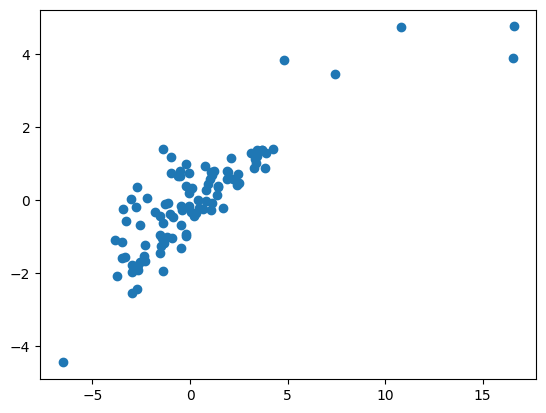

In [11]:
alpha = 1
c = np.linalg.solve(train_train_kernel + alpha * np.eye(train_train_kernel.shape[0]), train_energies)
test_predictions = train_test_kernel.T @ c
print("rmse: ", get_rmse(test_predictions, test_energies))

plt.plot(test_energies, test_predictions, 'o')
plt.show()

100%|██████████| 100/100 [00:02<00:00, 34.91it/s]


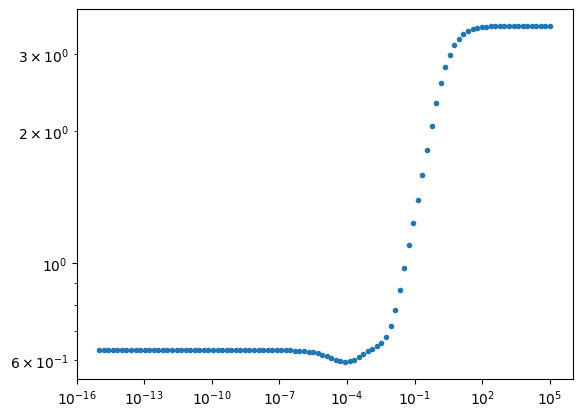

In [12]:
alpha_grid = np.logspace(5, -15, 100)
rmse = []
for alpha in tqdm.tqdm(alpha_grid):
    c = np.linalg.solve(train_train_kernel + alpha * np.eye(train_train_kernel.shape[0]), train_energies)
    test_predictions = train_test_kernel.T @ c
    rmse.append(get_rmse(test_predictions, test_energies))
plt.plot(alpha_grid, rmse, ".")
plt.xscale('log')
plt.yscale('log')
plt.show()

rmse:  0.593784086844665


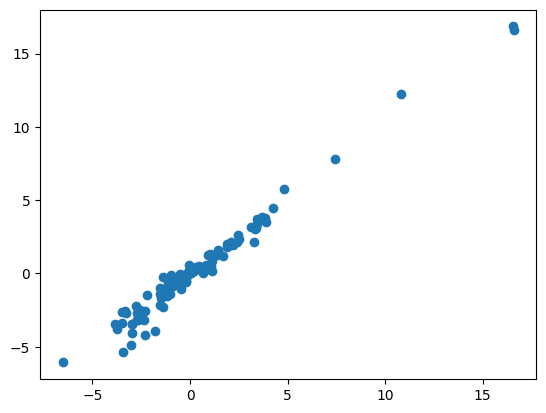

In [13]:
c = np.linalg.solve(train_train_kernel + alpha_grid[np.argmin(rmse)] * np.eye(train_train_kernel.shape[0]), train_energies)
test_predictions = train_test_kernel.T @ c
print("rmse: ", get_rmse(test_predictions, test_energies))
#print(predictions - test_energies)
plt.plot(test_energies, test_predictions, 'o')
plt.show()

In [14]:
np.save('test_saving', [test_energies, test_predictions])